# Set Up Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
#import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns
#import pandas as pd
#import math

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

sys.path.append('drive/MyDrive/LinAlgProject/')
from LayerVisualizer import *
from DataHelper import *
from TrainerHelper import *

# to make this notebook's output stable across runs
np.random.seed(42)

# Load the MNIST Data
Cell of code below is from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(trainset, [50000, 10000])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

100%|██████████| 9912422/9912422 [00:00<00:00, 99034590.04it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30397915.64it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 31411882.73it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5565448.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

## Visualize the MNIST Data

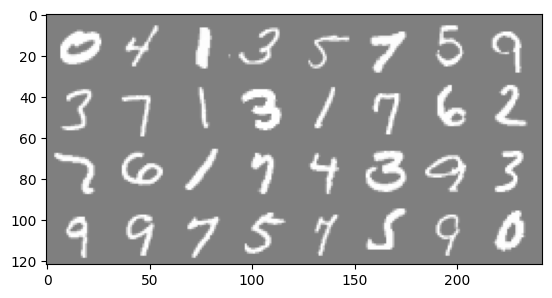

    0     4     1     3     5     7     5     9     3     7     1     3     1     7     6     2     7     6     1     7     4     3     9     3     9     9     7     5     7     5     9     0


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5d}' for j in range(batch_size)))

# General Model Environment Setup

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Simple Neural Network in PyTorch Example
Code snippets come from: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [7]:
# create the neural network class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_selu_stack = nn.Sequential(
            nn.Linear(28*28, 10),
            nn.SELU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_selu_stack(x)
        return logits

In [8]:
nn_model = NeuralNetwork().to(device)

## Step 1: Regularly Train the Model (Loss Function and Optimizer)
Code snippets from: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.001, momentum=0.9)

In [10]:
nn_model_trainer = TrainerHelper(nn_model, device, trainloader, valloader)

In [11]:
nn_model_trainer.custom_epoch_train(loss_fn, optimizer, n_epochs=20)

EPOCH 1:
  batch 1000 loss: 0.9259980797171593
LOSS train 0.9259980797171593 valid 0.5117823481559753
EPOCH 2:
  batch 1000 loss: 0.4771087674498558
LOSS train 0.4771087674498558 valid 0.42372217774391174
EPOCH 3:
  batch 1000 loss: 0.41809107732772827
LOSS train 0.41809107732772827 valid 0.3872769773006439
EPOCH 4:
  batch 1000 loss: 0.3878966681957245
LOSS train 0.3878966681957245 valid 0.3648603558540344
EPOCH 5:
  batch 1000 loss: 0.36620502575486896
LOSS train 0.36620502575486896 valid 0.35062843561172485
EPOCH 6:
  batch 1000 loss: 0.35371609055250886
LOSS train 0.35371609055250886 valid 0.34021103382110596
EPOCH 7:
  batch 1000 loss: 0.34433285835385324
LOSS train 0.34433285835385324 valid 0.33189821243286133
EPOCH 8:
  batch 1000 loss: 0.33503105749934914
LOSS train 0.33503105749934914 valid 0.3258649408817291
EPOCH 9:
  batch 1000 loss: 0.33243127722293137
LOSS train 0.33243127722293137 valid 0.32027387619018555
EPOCH 10:
  batch 1000 loss: 0.3256769996732473
LOSS train 0.3256

In [12]:
print("Current validation accuracy: " + str(nn_model_trainer.get_accuracy(valloader)))

Current validation accuracy: 0.9168


## Step 2: Visualizations

### Visualizing the Weights

In [13]:
visualizer = LayerVisualizer(nn_model_trainer.model, nn_model.linear_selu_stack, layer_num=0, input_dim=28)

In [14]:
print(visualizer.weights.shape)

(10, 784)


In [15]:
weights = visualizer.reshape_space(visualizer.weights.T)

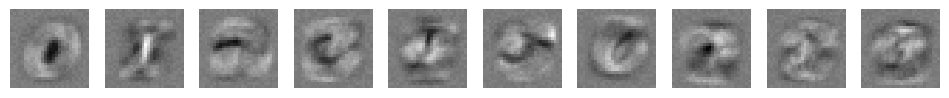

In [16]:
visualizer.visualize_space(weights)

### Row Space Visualizations

In [17]:
visualizer.extract_spaces()

In [18]:
# the original construction of the row space has the columns representing the 'spaces'
visualizer.row_space.shape

(784, 10)

In [19]:
print(visualizer.S.shape)
print(visualizer.row_space.shape)
signal_sp = np.multiply(visualizer.S, visualizer.row_space)
signal_sp = visualizer.reshape_space(signal_sp)

(10,)
(784, 10)


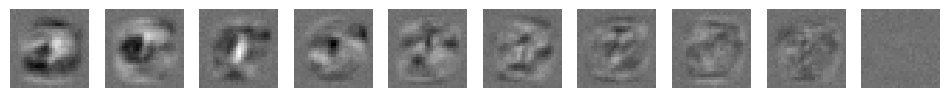

In [20]:
visualizer.visualize_space(signal_sp)

### Condition Number

In [21]:
# the singular values
visualizer.S

array([4.5066814 , 4.2620497 , 3.821146  , 3.2702382 , 2.7137005 ,
       2.5841074 , 2.1730912 , 2.023402  , 1.7672977 , 0.61501974],
      dtype=float32)

In [22]:
single_layer_cond = visualizer.S[0] / visualizer.S[-1]
print(single_layer_cond)

7.327702


### Average Image Visualization and Setup
Here we start using the DataHelper class, which will let us find the average picture for each class.

In [23]:
N_CLASSES = 10
IMG_SIZE = 28
data_visualizer = DataHelper(trainloader, n_classes=N_CLASSES)
images_by_class = data_visualizer.group_data_by_class()

In [24]:
input_image = data_visualizer.mean_class_image()

In [25]:
input_imgs = np.asarray([input_image[i] for i in range(N_CLASSES)])
# this is to create the right input for the visualization function
input_imgs = np.squeeze(input_imgs, axis=1)
input_imgs = input_imgs.T.swapaxes(0, 1)
print(input_imgs.shape)

(28, 28, 10)


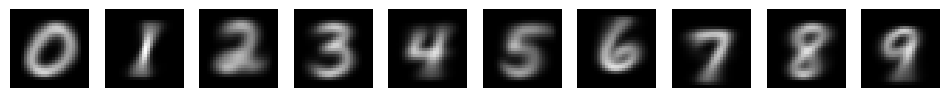

In [26]:
visualizer.visualize_space(input_imgs)

### Visualizing Residual


In [27]:
all_spaces = np.zeros((3, IMG_SIZE, IMG_SIZE, N_CLASSES)) # the 3 corresponds to the number of spaces to visualize

for label in range(N_CLASSES):
  avg = input_imgs[:, :, label]
  proj_out = visualizer.proj_weights(avg, visualizer.weights) # (10, 784)
  residuals = visualizer.residual_space_proj(avg.reshape((1, 28*28)), proj_out)

  proj_out = proj_out.T.reshape((IMG_SIZE, IMG_SIZE, N_CLASSES))
  residuals = residuals.T.reshape((IMG_SIZE, IMG_SIZE, N_CLASSES))

  all_spaces[0, :, :, label] = avg
  all_spaces[1, :, :, label] = visualizer.weights[label, :].reshape((IMG_SIZE, IMG_SIZE))
  all_spaces[2, :, :, label] = residuals[:, :, label]

<Figure size 300x1000 with 0 Axes>

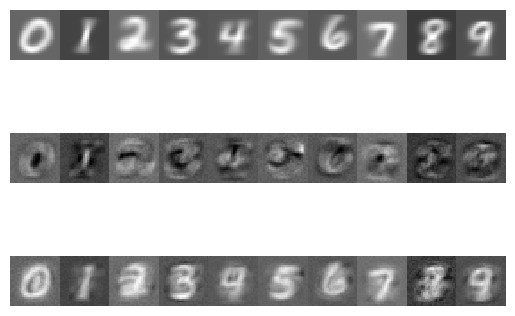

In [28]:
visualizer.visualize_space(all_spaces)

## Step 3: Invertable Neural Nets Example

### Plot the Raw Scores

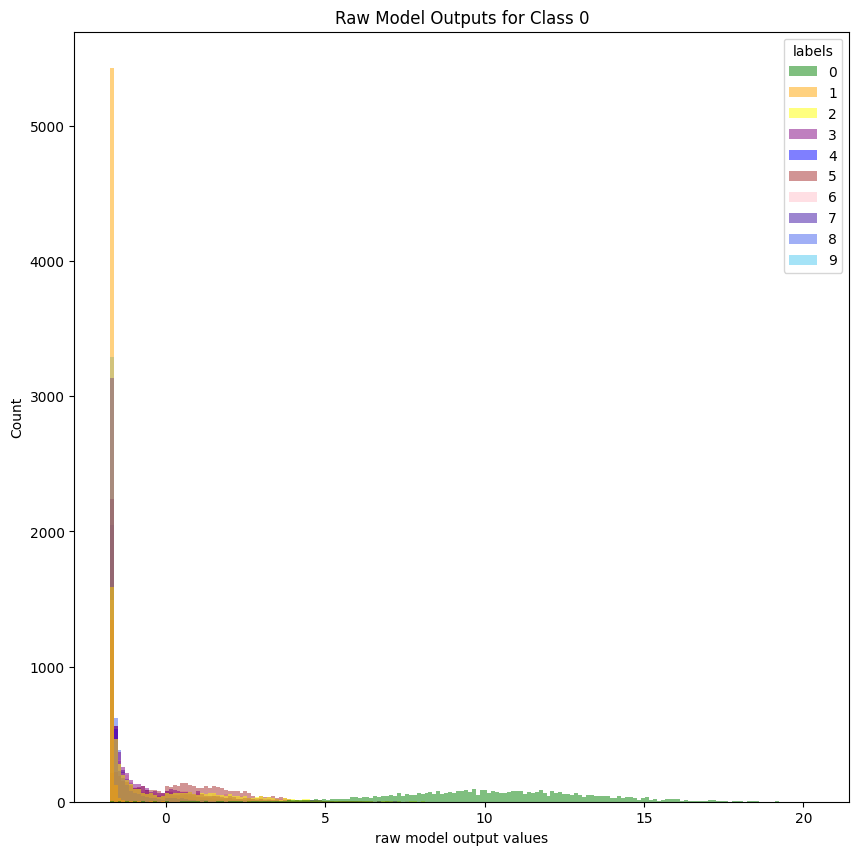

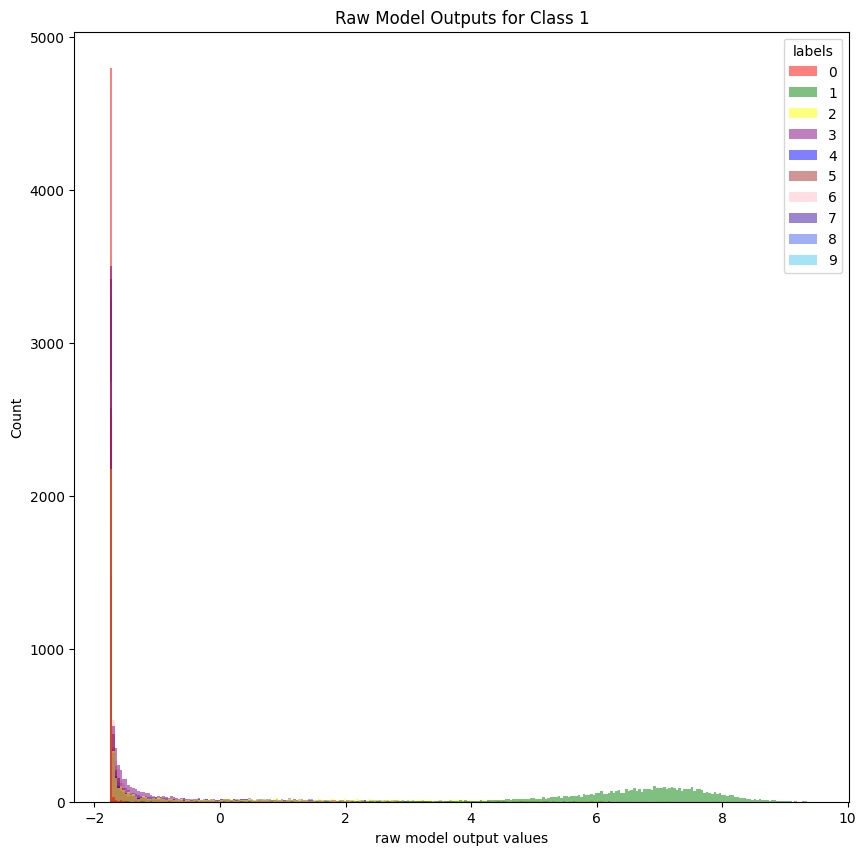

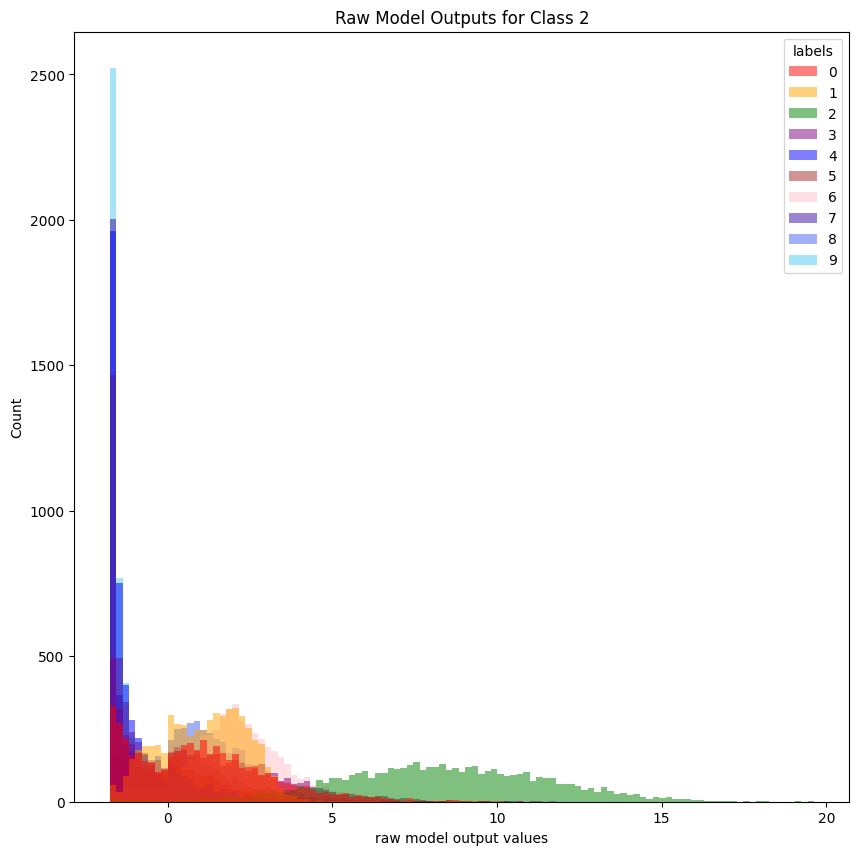

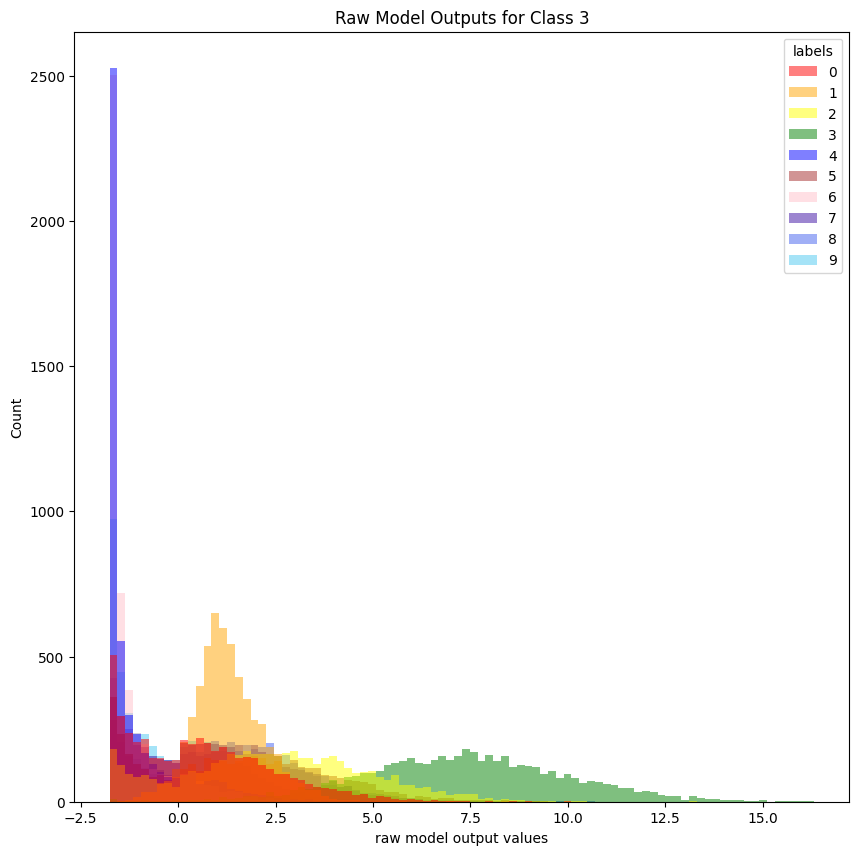

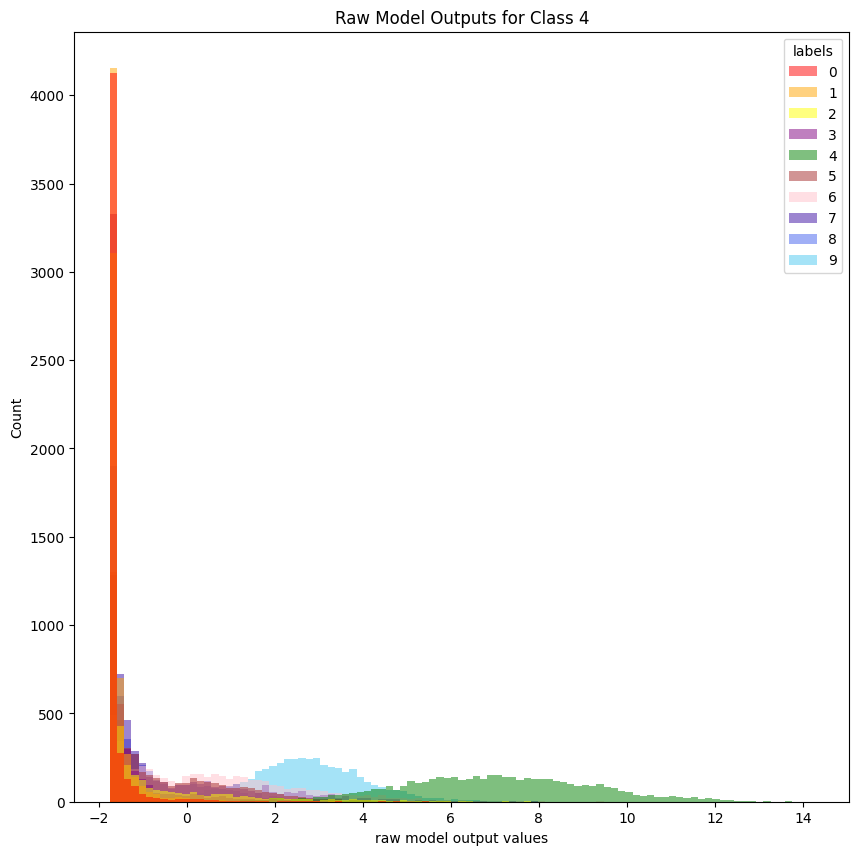

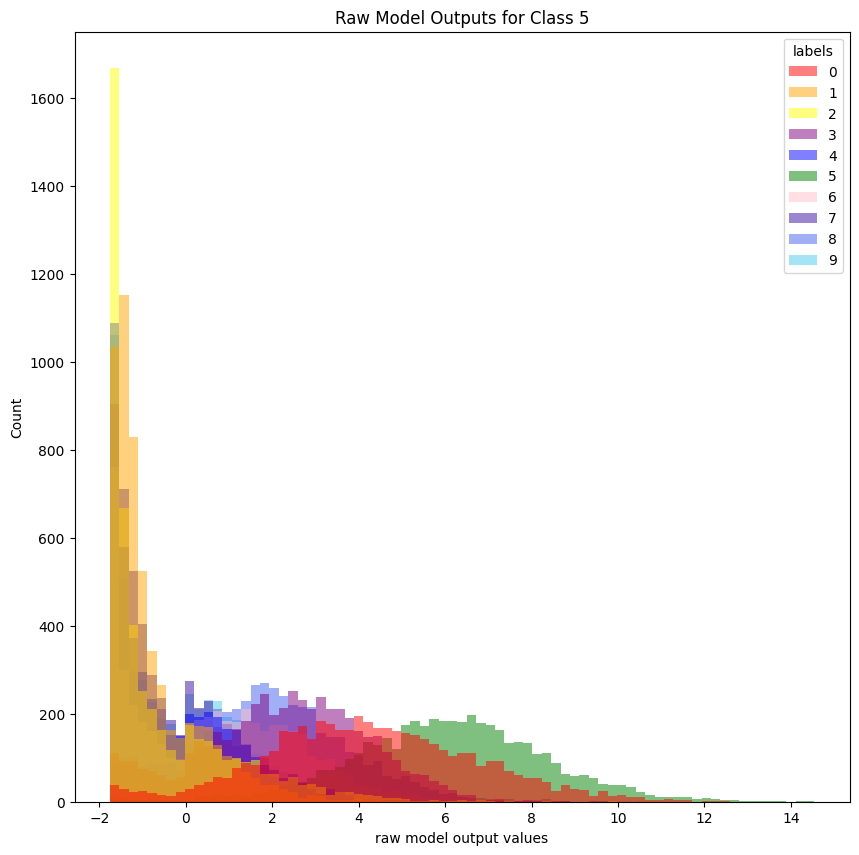

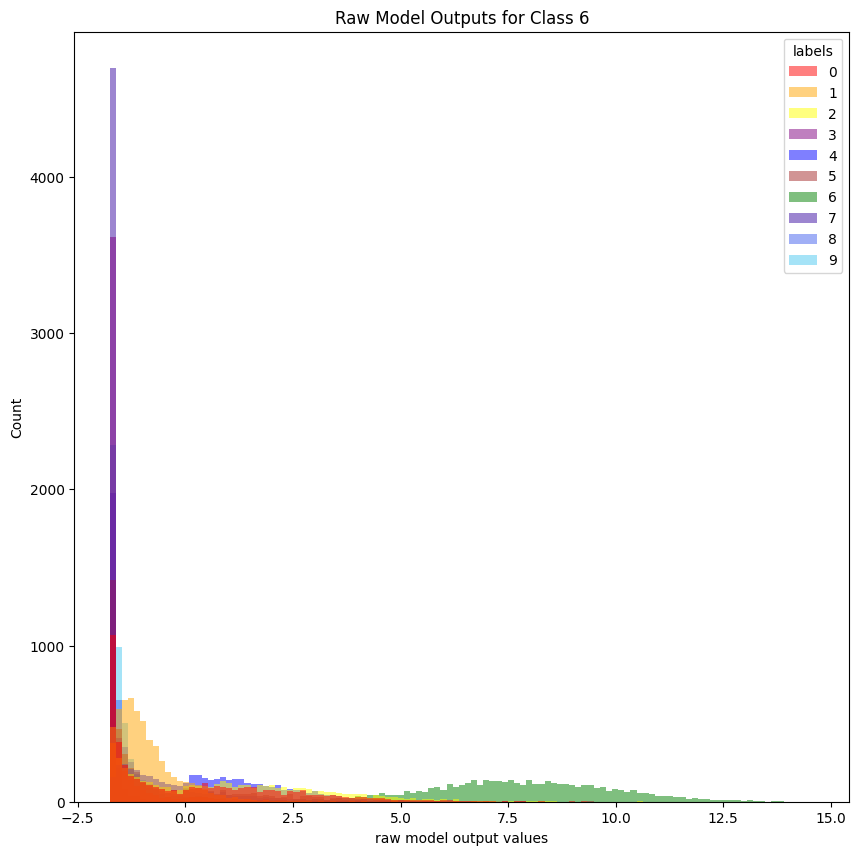

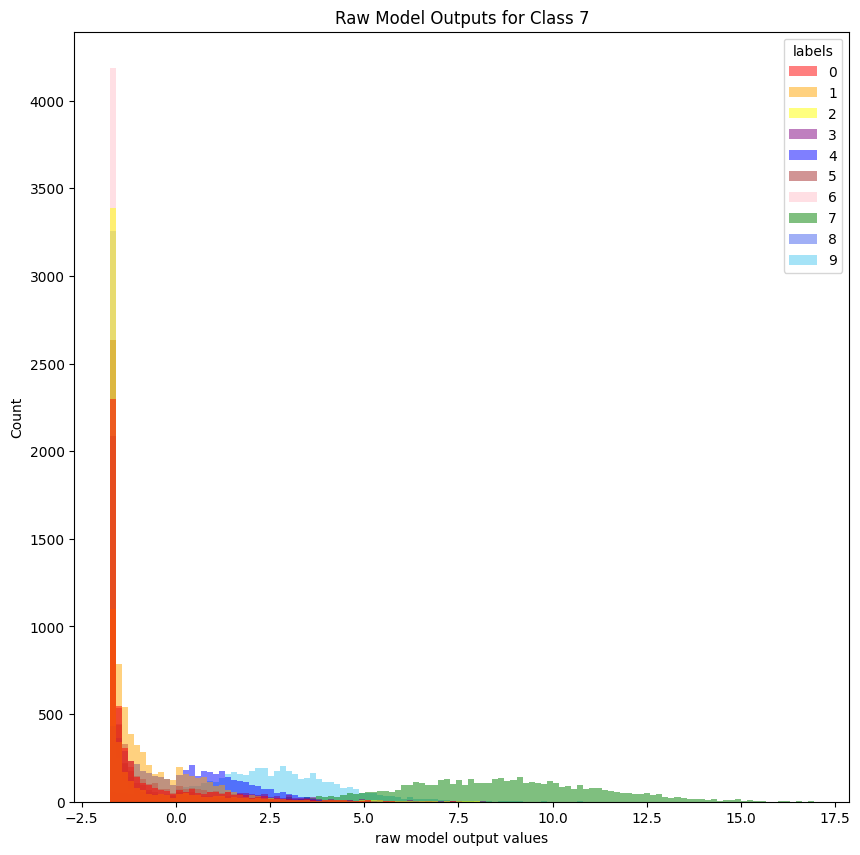

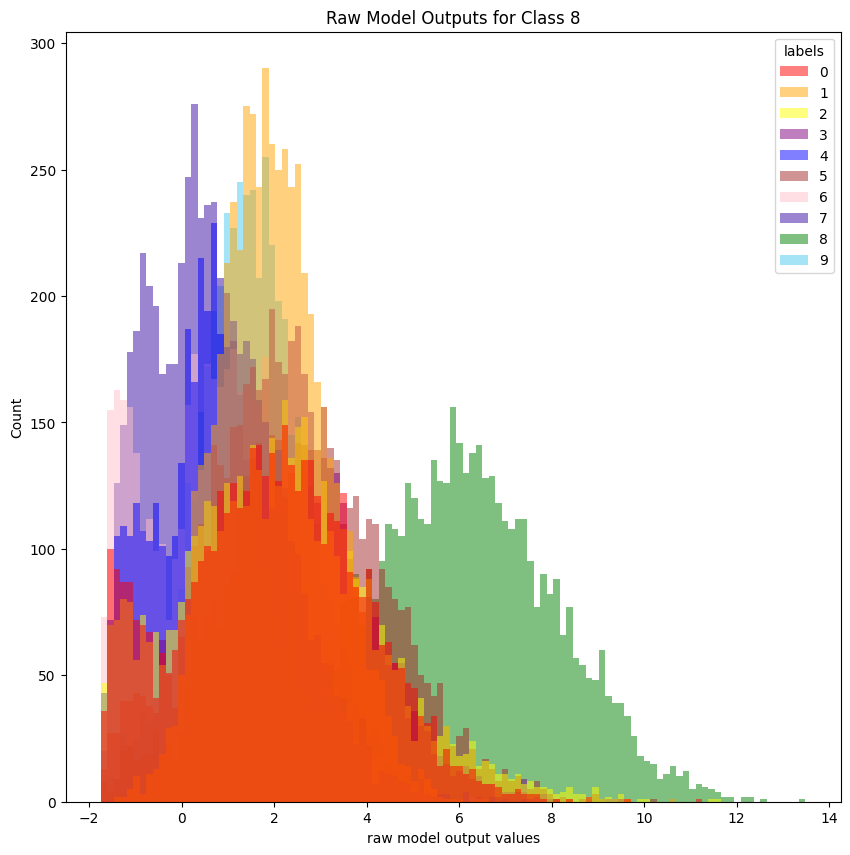

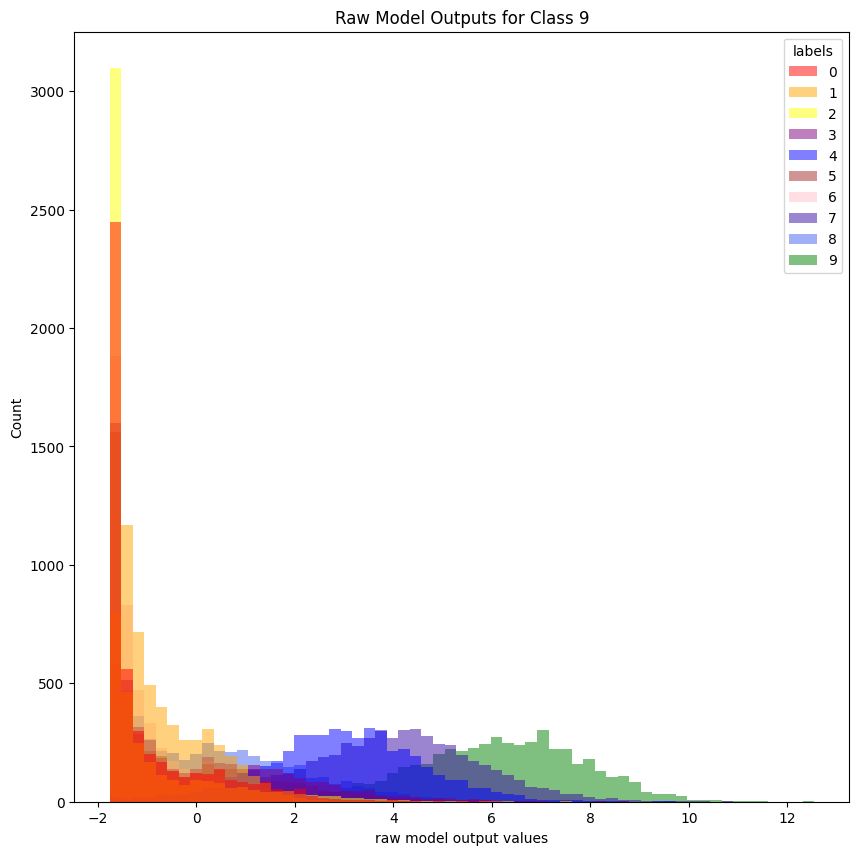

In [29]:
data_path = "drive/MyDrive/LinAlgProject/graphs/single_layer/raw_histogram_class"
hist_counts = data_visualizer.get_class_count(nn_model_trainer.model)
data_visualizer.plot_raw_histograms(hist_counts, data_path)

### Retraining Helper Function Based on Min/Max or 25th/75th of Each Class

In [30]:
img_classes = data_visualizer.group_data_by_class()

/content/drive/MyDrive/LinAlgProject/TrainerHelper.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = Variable(torch.tensor(target), requires_grad=False)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Current loss before training: tensor(7.0385)
EPOCH 1:
Current loss: tensor(7.0385, grad_fn=<MseLossBackward0>)
EPOCH 2:
Current loss: tensor(7.0362, grad_fn=<MseLossBackward0>)
EPOCH 3:
Current loss: tensor(7.0340, grad_fn=<MseLossBackward0>)
EPOCH 4:
Current loss: tensor(7.0318, grad_fn=<MseLossBackward0>)
EPOCH 5:
Current loss: tensor(7.0295, grad_fn=<MseLossBackward0>)
EPOCH 6:
Current loss: tensor(7.0273, grad_fn=<MseLossBackward0>)
EPOCH 7:
Current loss: tensor(7.0250, grad_fn=<MseLossBackward0>)
EPOCH 8:
Current loss: tensor(7.0228, grad_fn=<MseLossBackward0>)
EPOCH 9:
Current loss: tensor(7.0206, grad_fn=<MseLossBackward0>)
EPOCH 10:
Current loss: tensor(7.0184, grad_fn=<MseLossBackward0>)
EPOCH 11:
Current loss: tensor(7.0161, grad_fn=<MseLossBackward0>)
EPOCH 12:
Current loss: tensor(7.0139, grad_fn=<MseLossBackward0>)
EPOCH 13:
Current loss: tensor(7.0117, grad_fn=<MseLossBackward0>)
EPOCH 14:
Current loss: tensor(7.0094, grad_fn=<MseLossBackward0>)
EPOCH 15:
Current loss: te

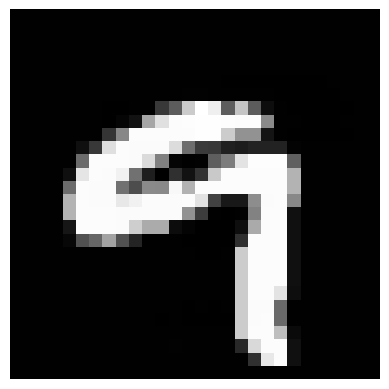

In [31]:
# NOTE: will not print the images, but rather save them in specific folder (last param in function below)
nn_model_trainer.find_invertable_input(hist_counts, None, 10, img_class_dict=img_classes, save_path='drive/MyDrive/LinAlgProject/graphs/single_layer/invert_closest_image_class')

# Multi-Layer Neural Network Example

## Step 1: Train Multi-Layer Network (+ Setup)

In [32]:
class MultiLayerNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_selu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.SELU(),
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, 128),
            nn.SELU(),
            nn.Linear(128, 32),
            nn.SELU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_selu_stack(x)
        return logits

In [33]:
multi_layer_model = MultiLayerNeuralNetwork().to(device)
print(multi_layer_model)

MultiLayerNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_selu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): SELU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SELU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SELU()
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): SELU()
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [34]:
multi_trainer = TrainerHelper(multi_layer_model, device, trainloader, valloader)

In [35]:
loss_fn = torch.nn.CrossEntropyLoss()

In [36]:
optimizer = torch.optim.SGD(multi_layer_model.parameters(), lr=0.001, momentum=0.9)

In [37]:
multi_trainer.custom_epoch_train(loss_fn, optimizer, n_epochs=20)

EPOCH 1:
  batch 1000 loss: 0.9992104697525501
LOSS train 0.9992104697525501 valid 0.3565232753753662
EPOCH 2:
  batch 1000 loss: 0.33627642449736594
LOSS train 0.33627642449736594 valid 0.2930499017238617
EPOCH 3:
  batch 1000 loss: 0.27287038910761474
LOSS train 0.27287038910761474 valid 0.24907273054122925
EPOCH 4:
  batch 1000 loss: 0.24388636614196002
LOSS train 0.24388636614196002 valid 0.22626613080501556
EPOCH 5:
  batch 1000 loss: 0.21837097148317844
LOSS train 0.21837097148317844 valid 0.205196812748909
EPOCH 6:
  batch 1000 loss: 0.1988796399757266
LOSS train 0.1988796399757266 valid 0.18998856842517853
EPOCH 7:
  batch 1000 loss: 0.18175974802020936
LOSS train 0.18175974802020936 valid 0.17177151143550873
EPOCH 8:
  batch 1000 loss: 0.16115008576586842
LOSS train 0.16115008576586842 valid 0.1589428186416626
EPOCH 9:
  batch 1000 loss: 0.15090005057351663
LOSS train 0.15090005057351663 valid 0.1480439454317093
EPOCH 10:
  batch 1000 loss: 0.1382885679360479
LOSS train 0.1382

In [38]:
print("Validation accuracy: " + str(multi_trainer.get_accuracy(valloader)))

Validation accuracy: 0.9677


## Step 2: Invertability for Each Class

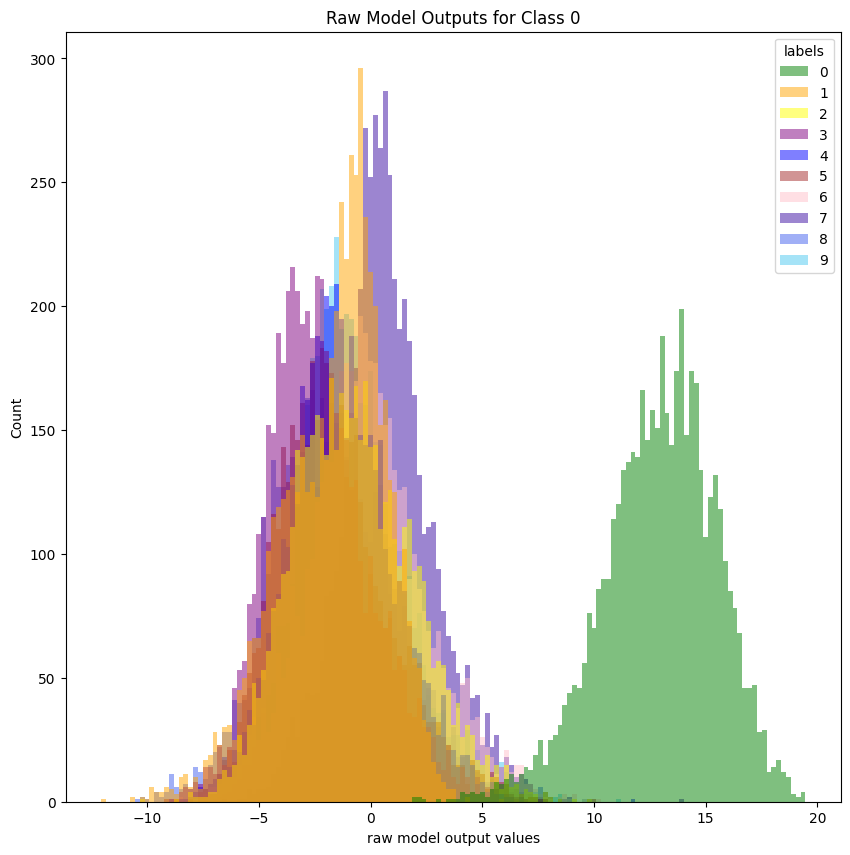

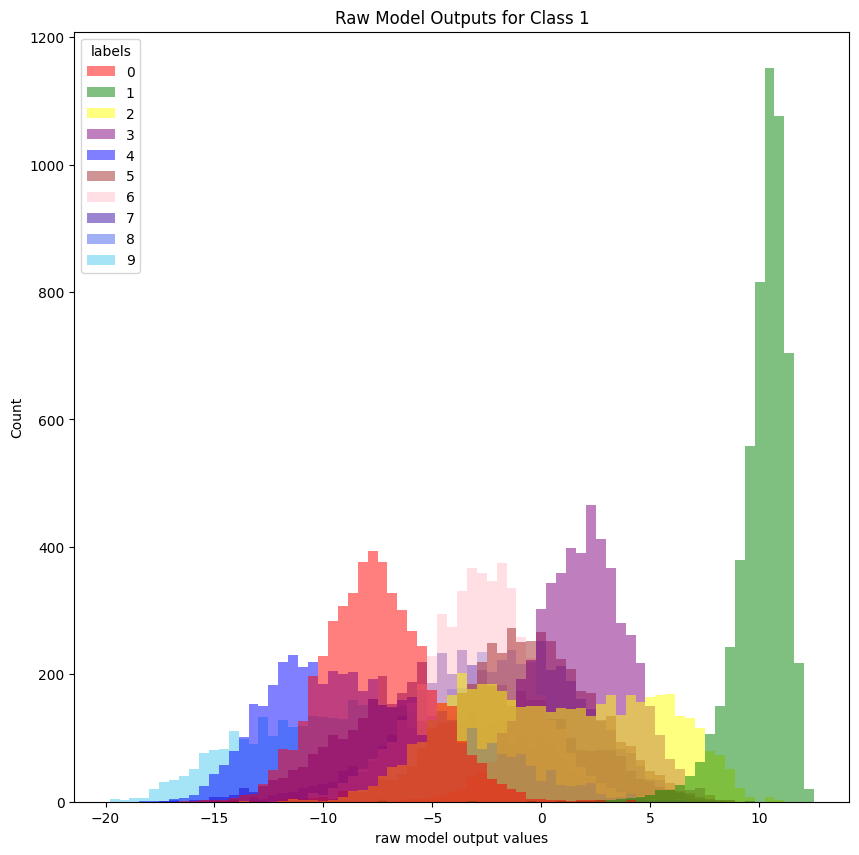

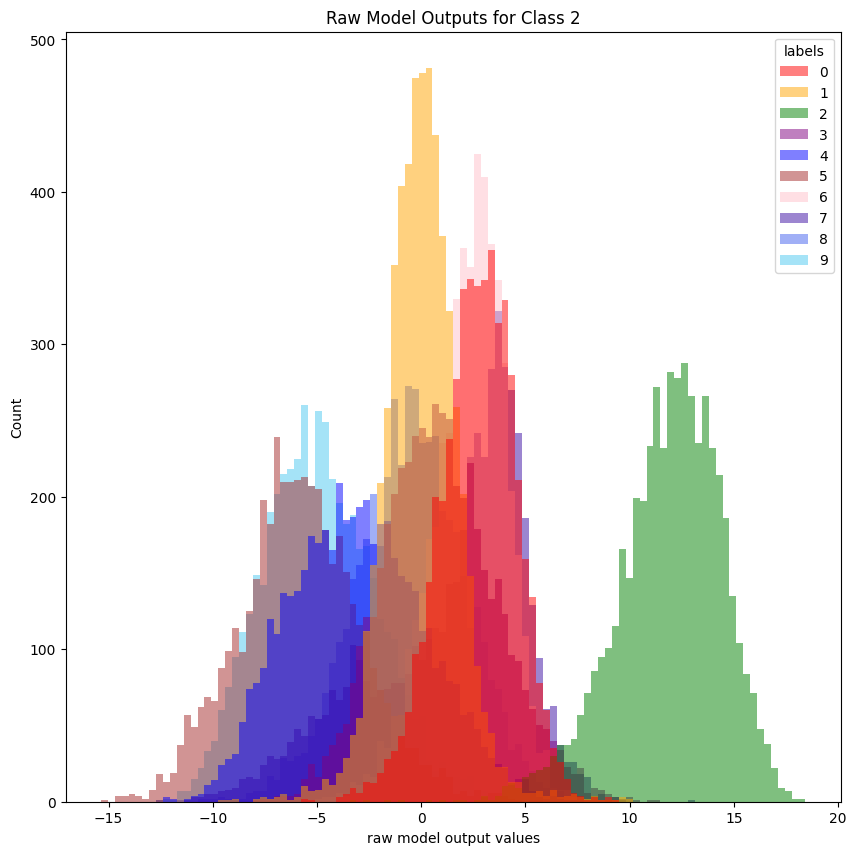

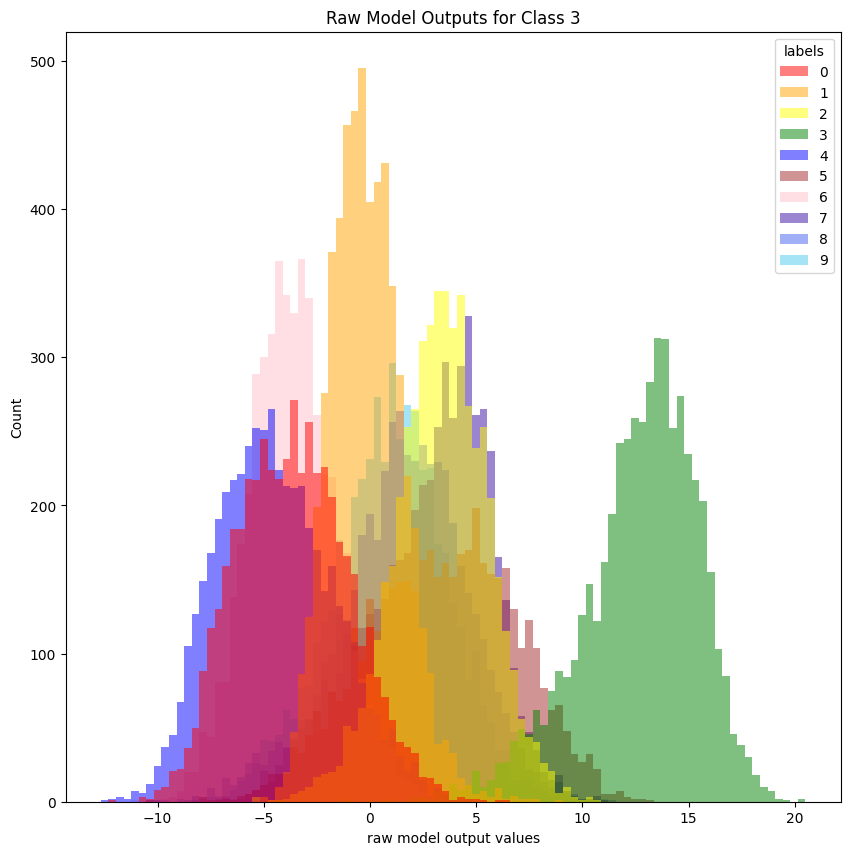

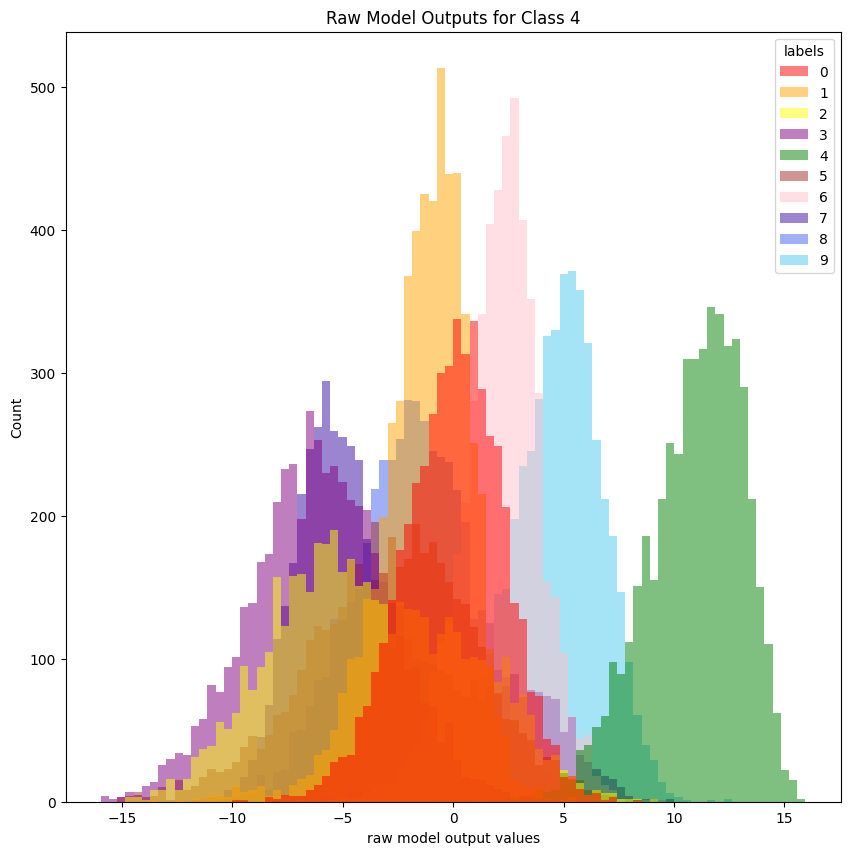

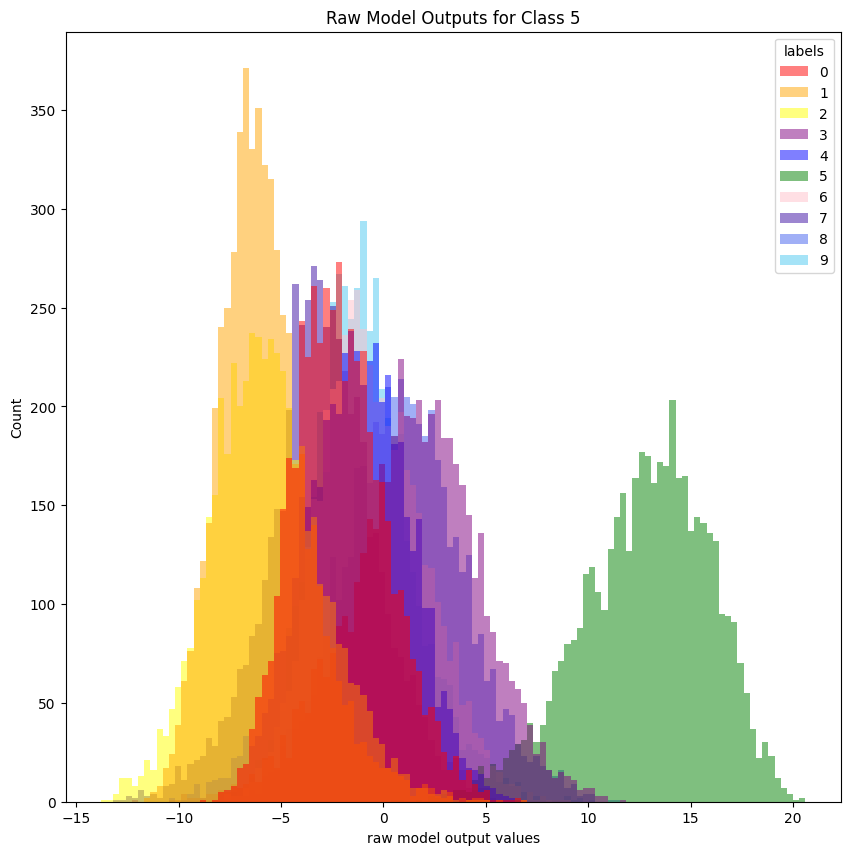

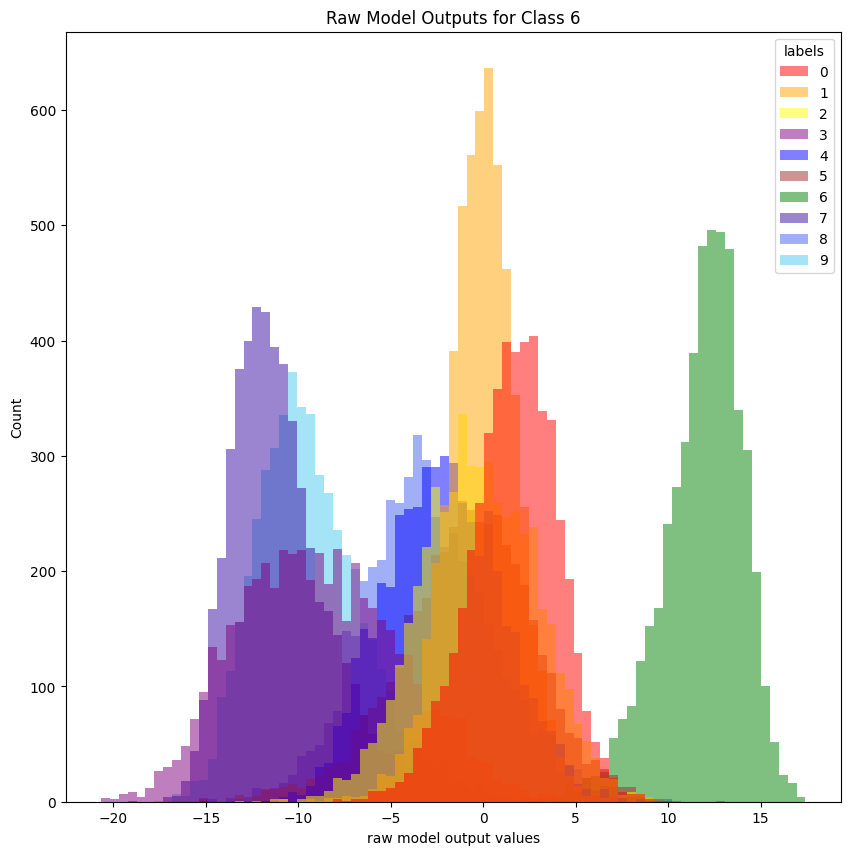

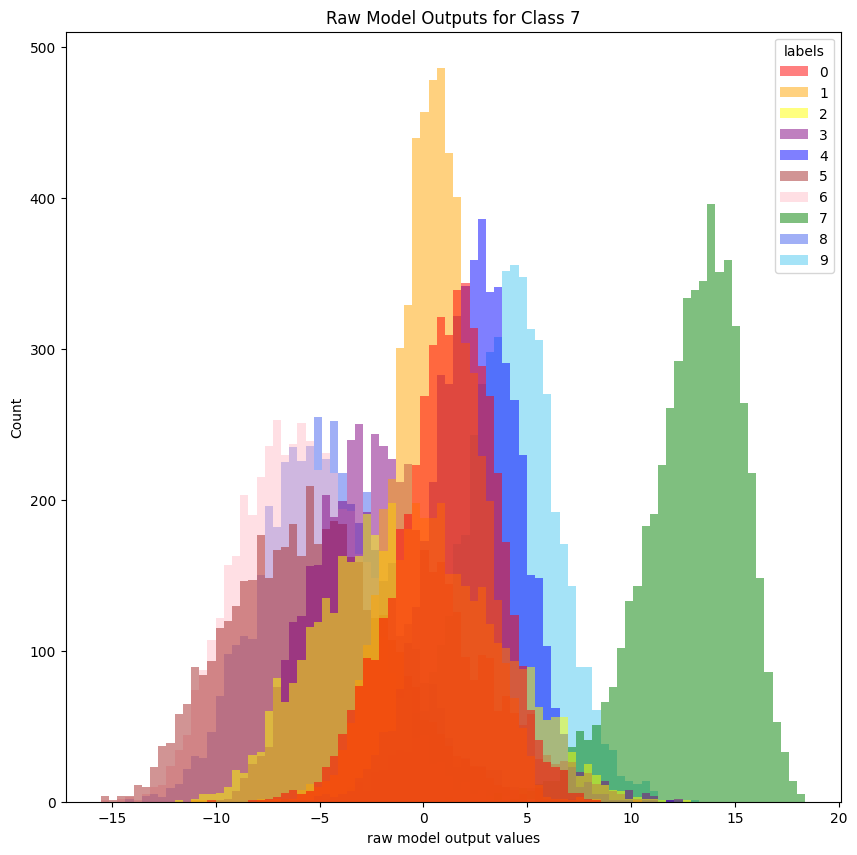

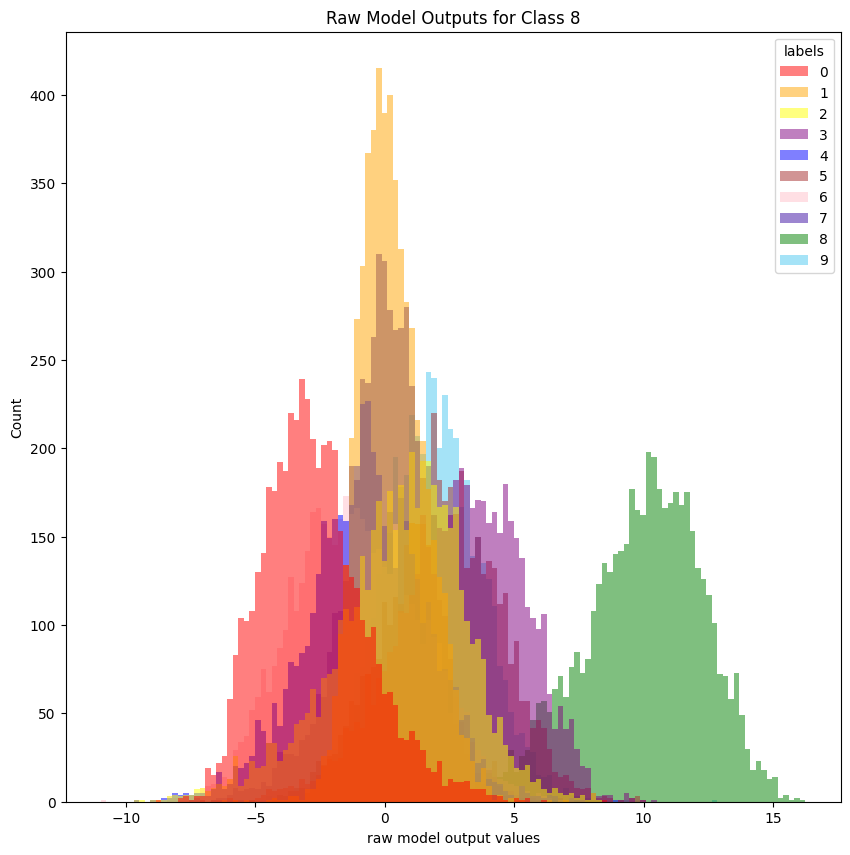

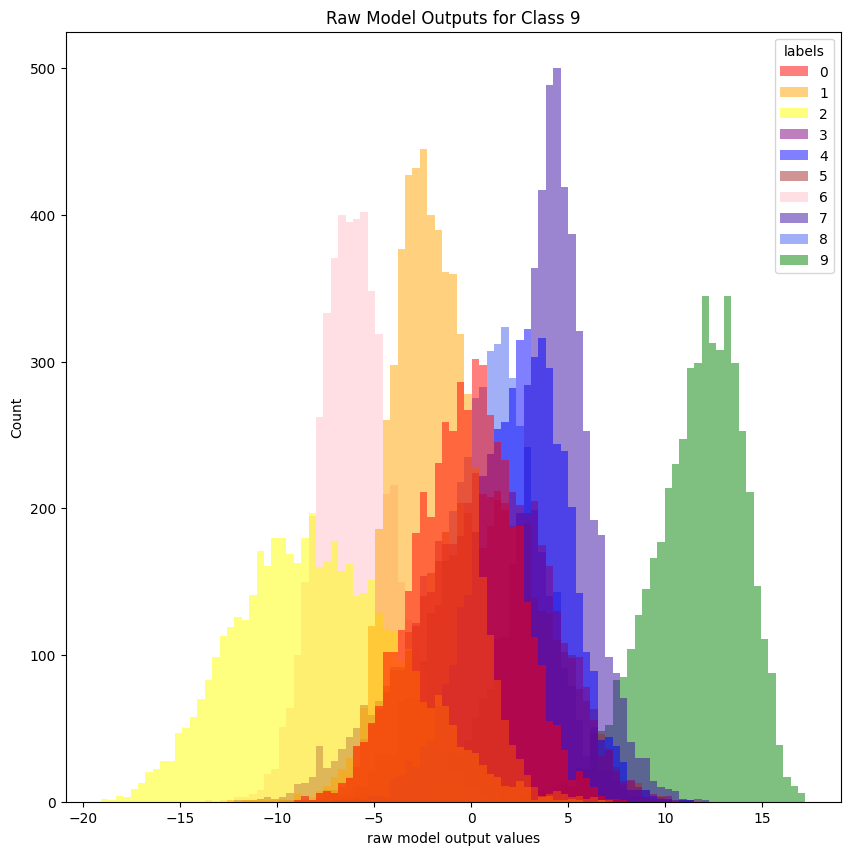

In [39]:
data_path = "drive/MyDrive/LinAlgProject/graphs/multi_layer/raw_histogram_class"
multi_hist_counts = data_visualizer.get_class_count(multi_layer_model)
data_visualizer.plot_raw_histograms(multi_hist_counts, data_path)

/content/drive/MyDrive/LinAlgProject/TrainerHelper.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = Variable(torch.tensor(target), requires_grad=False)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Current loss before training: tensor(106.6691)
EPOCH 1:
Current loss: tensor(106.6691, grad_fn=<MseLossBackward0>)
EPOCH 2:
Current loss: tensor(106.6648, grad_fn=<MseLossBackward0>)
EPOCH 3:
Current loss: tensor(106.6602, grad_fn=<MseLossBackward0>)
EPOCH 4:
Current loss: tensor(106.6554, grad_fn=<MseLossBackward0>)
EPOCH 5:
Current loss: tensor(106.6505, grad_fn=<MseLossBackward0>)
EPOCH 6:
Current loss: tensor(106.6456, grad_fn=<MseLossBackward0>)
EPOCH 7:
Current loss: tensor(106.6408, grad_fn=<MseLossBackward0>)
EPOCH 8:
Current loss: tensor(106.6360, grad_fn=<MseLossBackward0>)
EPOCH 9:
Current loss: tensor(106.6312, grad_fn=<MseLossBackward0>)
EPOCH 10:
Current loss: tensor(106.6267, grad_fn=<MseLossBackward0>)
EPOCH 11:
Current loss: tensor(106.6223, grad_fn=<MseLossBackward0>)
EPOCH 12:
Current loss: tensor(106.6178, grad_fn=<MseLossBackward0>)
EPOCH 13:
Current loss: tensor(106.6134, grad_fn=<MseLossBackward0>)
EPOCH 14:
Current loss: tensor(106.6090, grad_fn=<MseLossBackward

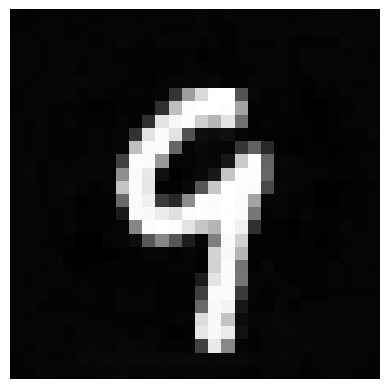

In [40]:
loss_fn_mse = torch.nn.MSELoss()
multi_trainer.find_invertable_input(multi_hist_counts, None, n_classes=10, img_class_dict=img_classes, model_type="fcnn", save_path='drive/MyDrive/LinAlgProject/graphs/multi_layer/closest_invert_image_class')

# ResNet18 Example

## Step 1: Train / Load ResNet

In [41]:
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models import resnet18
from torch import nn

class ResnetMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    def forward(self, x):
        logits = self.model(x)
        return logits

### Option 1: Train ResNet18 from scratch

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
resnet_model = ResnetMNIST().to(device)
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
resnet_trainer = TrainerHelper(resnet_model, device, trainloader, valloader)

In [ ]:
resnet_trainer.custom_epoch_train(loss_fn, optimizer, n_epochs=20)

EPOCH 1:
  batch 1000 loss: 0.0011247830277666252
LOSS train 0.0011247830277666252 valid 0.03264588490128517
EPOCH 2:
  batch 1000 loss: 0.0006128772863869472
LOSS train 0.0006128772863869472 valid 0.036036040633916855
EPOCH 3:
  batch 1000 loss: 0.0004910383463204653
LOSS train 0.0004910383463204653 valid 0.03373242914676666
EPOCH 4:
  batch 1000 loss: 0.000401606908617623
LOSS train 0.000401606908617623 valid 0.0324087031185627
EPOCH 5:
  batch 1000 loss: 0.00032353137525910824
LOSS train 0.00032353137525910824 valid 0.033781424164772034
EPOCH 6:
  batch 1000 loss: 0.00043612747950419364
LOSS train 0.00043612747950419364 valid 0.03425129875540733
EPOCH 7:
  batch 1000 loss: 0.0006698515223101821
LOSS train 0.0006698515223101821 valid 0.03335237503051758
EPOCH 8:
  batch 1000 loss: 0.00044879258054083946
LOSS train 0.00044879258054083946 valid 0.034504059702157974
EPOCH 9:
  batch 1000 loss: 0.0002830072718604697
LOSS train 0.0002830072718604697 valid 0.033765845000743866
EPOCH 10:
  

In [ ]:
print("Validation accuracy: " + str(resnet_trainer.get_accuracy(valloader)))

Validation accuracy: 0.9922


In [ ]:
model_path = 'drive/MyDrive/LinAlgProject/final_model_resnet'
torch.save(resnet_trainer.model.state_dict(), model_path)

In [ ]:
resnet_trainer.model

ResnetMNIST(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

### Option 2: Load from a previous path

In [42]:
resnet_model = ResnetMNIST()
PATH = "drive/MyDrive/LinAlgProject/final_model_resnet"
resnet_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Printing Accuracy

In [43]:
def get_accuracy(model, valloader):
  correct = 0.
  total = 0.
  softmax = nn.Softmax(dim=1)

  for data in valloader:
    inputs, labels = data
    total += len(inputs)
    outputs = model(inputs)
    probs = softmax(outputs)
    outputs = torch.argmax(probs, dim=-1)
    correct += (outputs == labels).sum().item()
  accuracy = correct / total
  return accuracy

In [44]:
get_accuracy(resnet_model, valloader)

0.9988

## Step 2: Visualize first 2D conv layers

In [45]:
resnet_layer = resnet_model.model.layer1[0].conv1
in_c, out_c, kern_size, _ = resnet_layer.weight.detach().numpy().shape

In [46]:
resnet_visualizer = LayerVisualizer(resnet_model, resnet_layer, None, input_dim=64)
print(resnet_visualizer.weights.shape)

(4096, 9)


In [47]:
resnet_visualizer.extract_spaces()

### Condition Number + VIsualization of Signal Space

In [48]:
resnet_visualizer.S
cond = resnet_visualizer.S[0] / resnet_visualizer.S[-1]
print(cond)

1.0694451


In [53]:
resnet_visualizer.row_space

array([[ 0.46050406, -0.11588302,  0.6652557 , -0.27111456,  0.14782614,
        -0.08420926,  0.2210764 , -0.42336857, -0.03713956],
       [-0.12468708, -0.57925427,  0.16140826,  0.01726869,  0.18046485,
         0.25763163,  0.23957537,  0.3509881 ,  0.5856929 ],
       [ 0.15770395, -0.5176616 , -0.2770664 , -0.56532437, -0.12310625,
        -0.12291124,  0.01020322,  0.26680246, -0.45743695],
       [ 0.6192936 ,  0.0553312 , -0.5313827 , -0.01152004,  0.43338013,
         0.25450522, -0.10556562, -0.14255004,  0.21646675],
       [ 0.48922035, -0.08312006,  0.07318532,  0.5737861 , -0.10384177,
        -0.4511319 ,  0.12074368,  0.42685407, -0.08989647],
       [-0.13716751, -0.58078927, -0.20752695,  0.36212754, -0.0893356 ,
        -0.22578365, -0.16229953, -0.61992455,  0.0076413 ],
       [ 0.27125037,  0.06983842, -0.06535286, -0.22034667, -0.7697157 ,
        -0.03271069, -0.14215802, -0.06606154,  0.5006165 ],
       [-0.15291229,  0.17287074, -0.32837313, -0.18519253,  0

In [57]:
resnet_visualizer.visualize_space(resnet_visualizer.row_space)

In [58]:
resnet_signal = np.multiply(resnet_visualizer.S, resnet_visualizer.row_space)
resnet_signal = resnet_visualizer.reshape_space(resnet_signal)

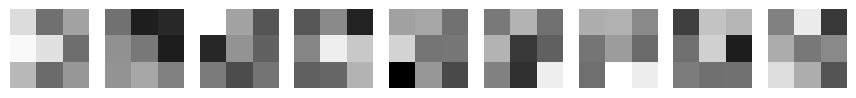

In [59]:
resnet_visualizer.visualize_space(resnet_signal)

## Step 2: Re-training the Input for Resnet

In [60]:
data_path = "drive/MyDrive/LinAlgProject/graphs/resnet/raw_histogram_class"
# NOTE: for resnet we should not be flattening
resnet_hist_counts = data_visualizer.get_class_count(resnet_model, "resnet")

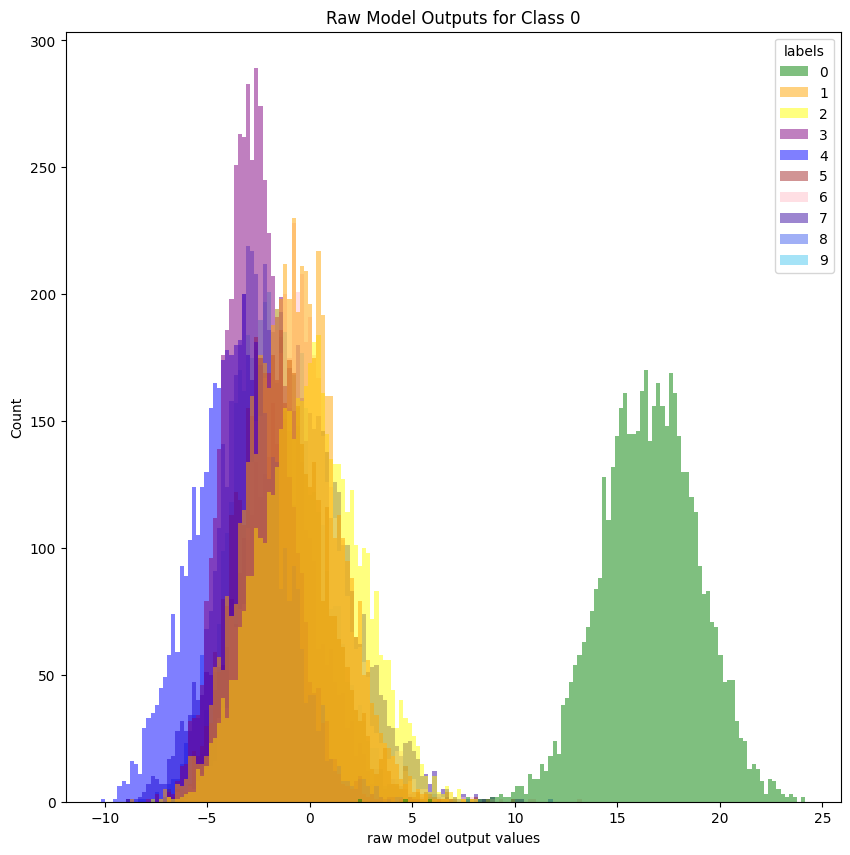

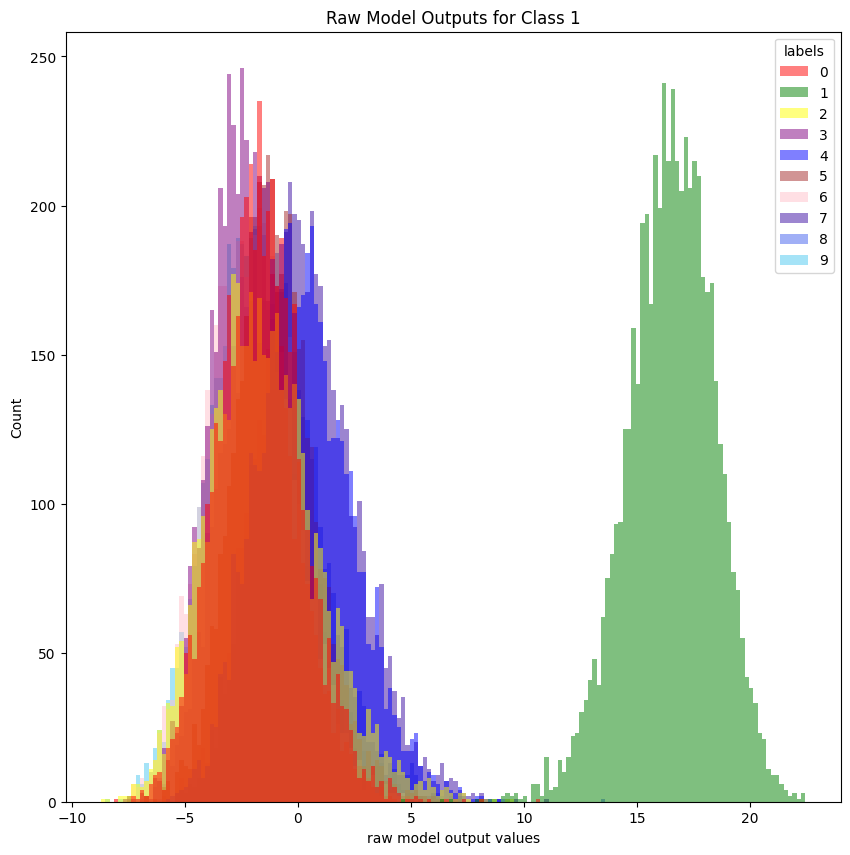

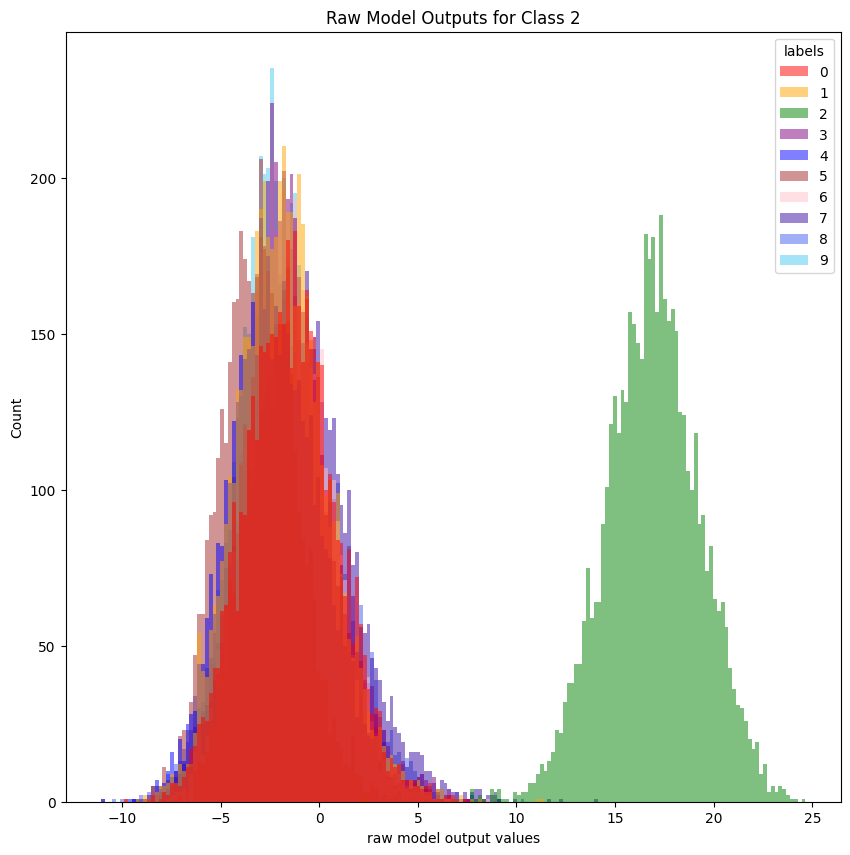

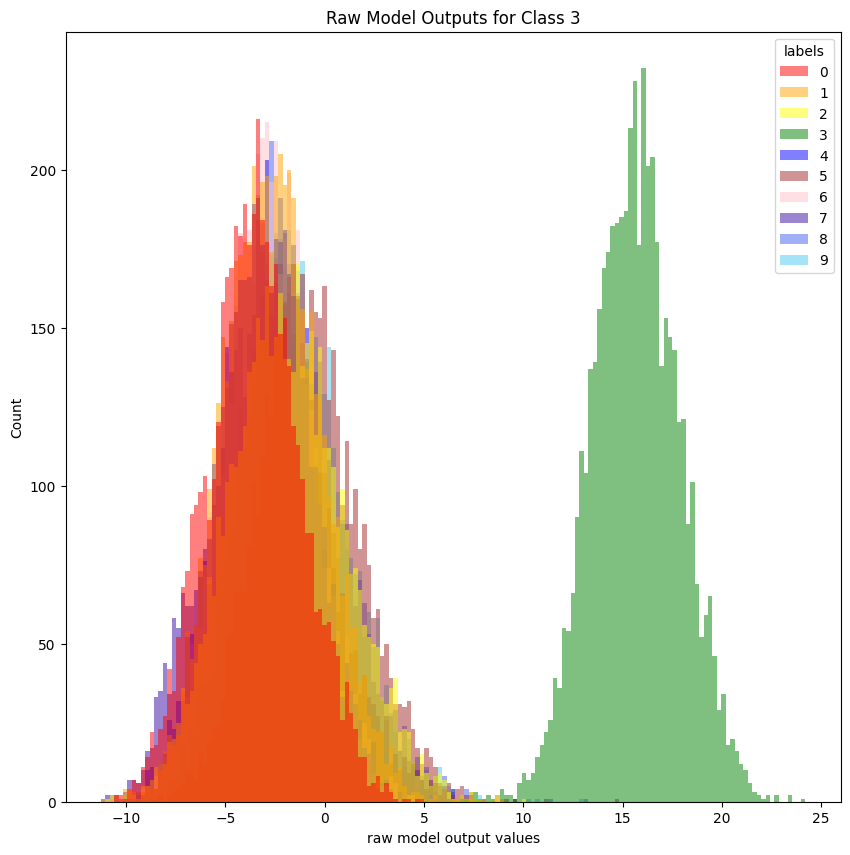

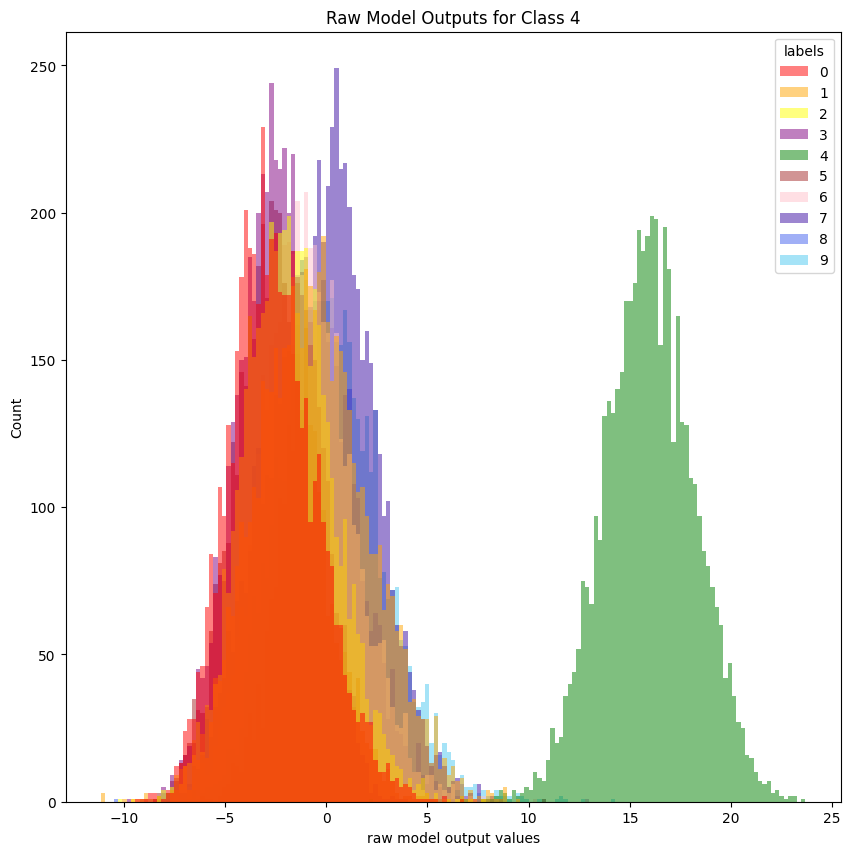

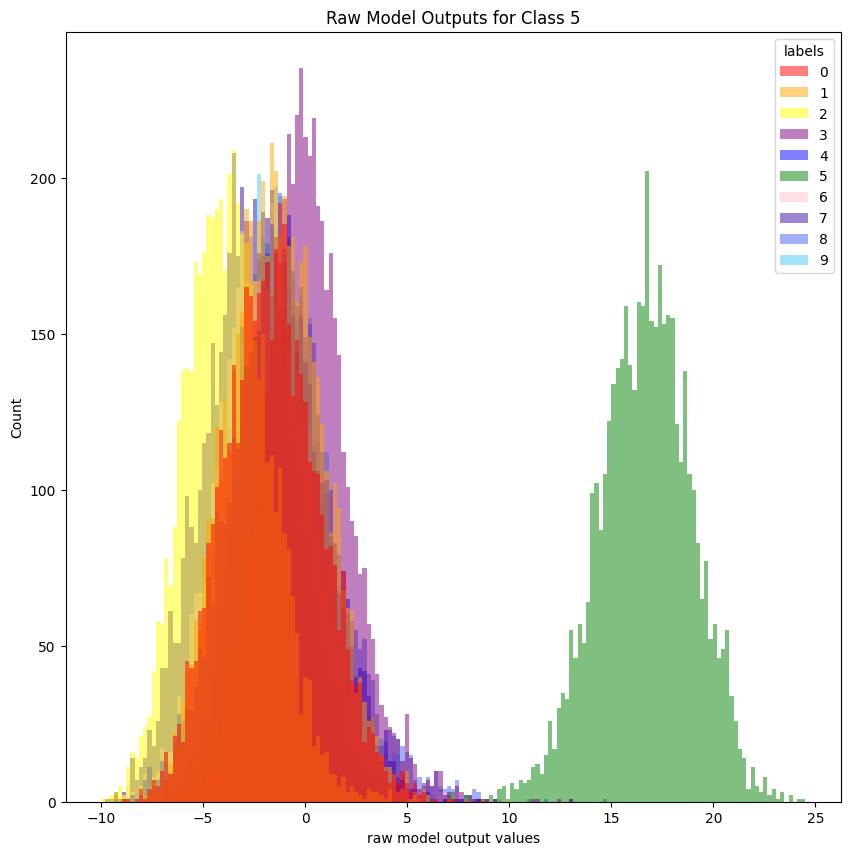

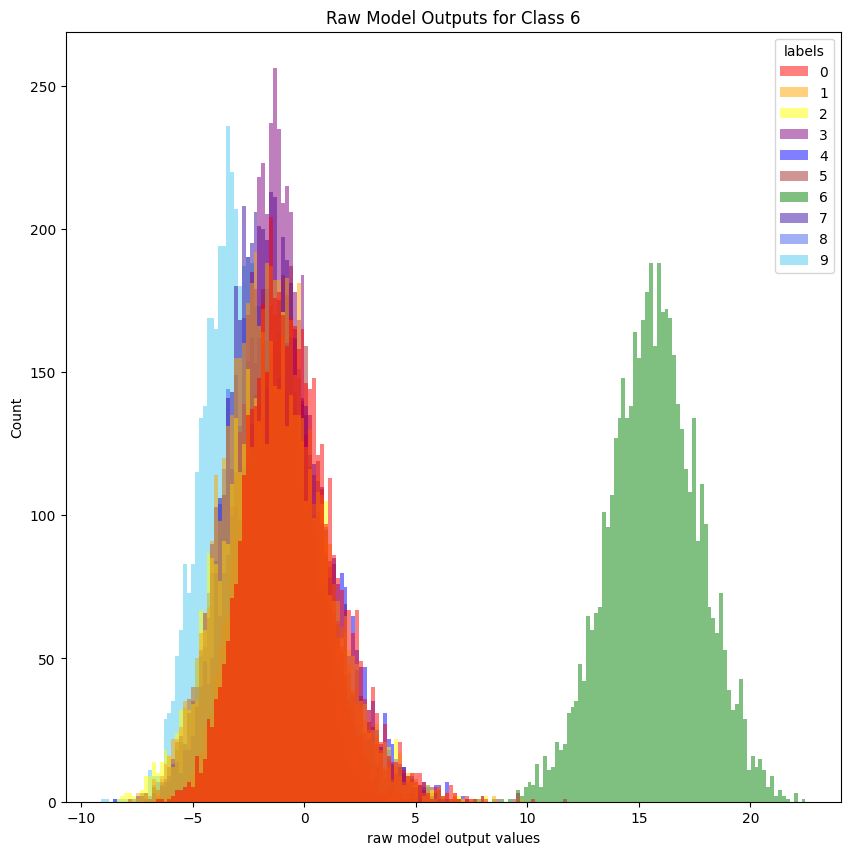

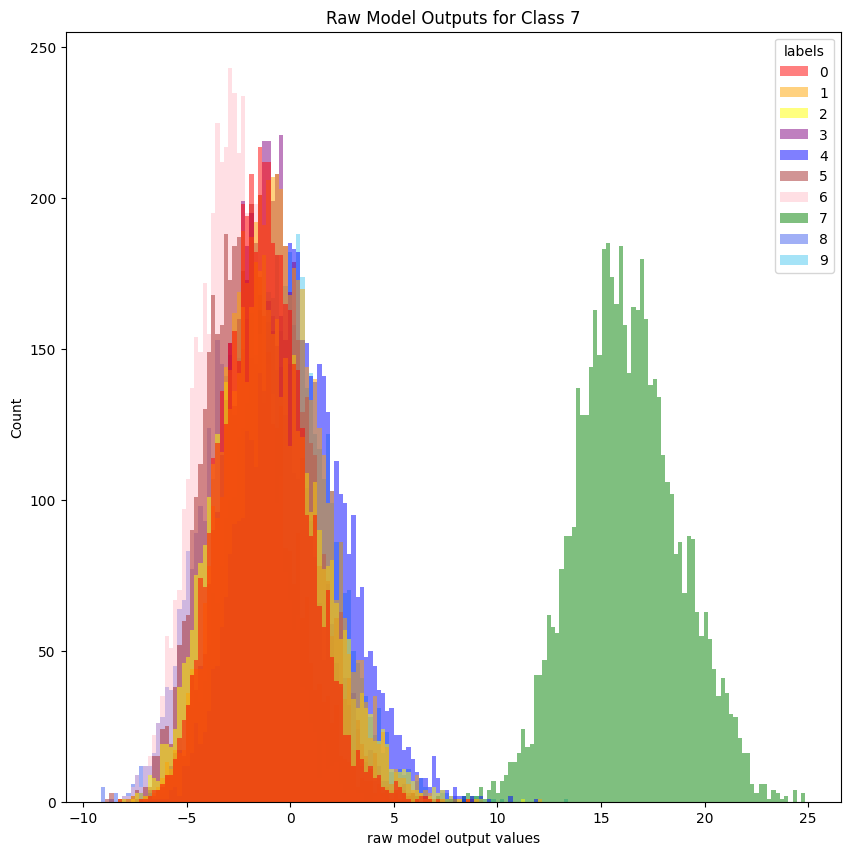

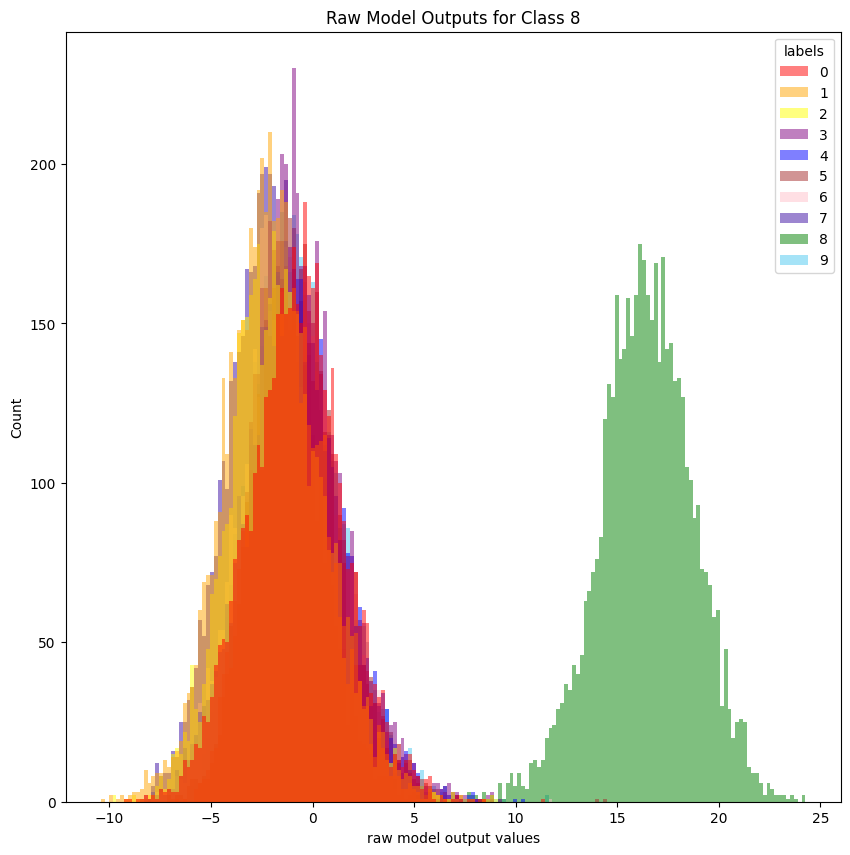

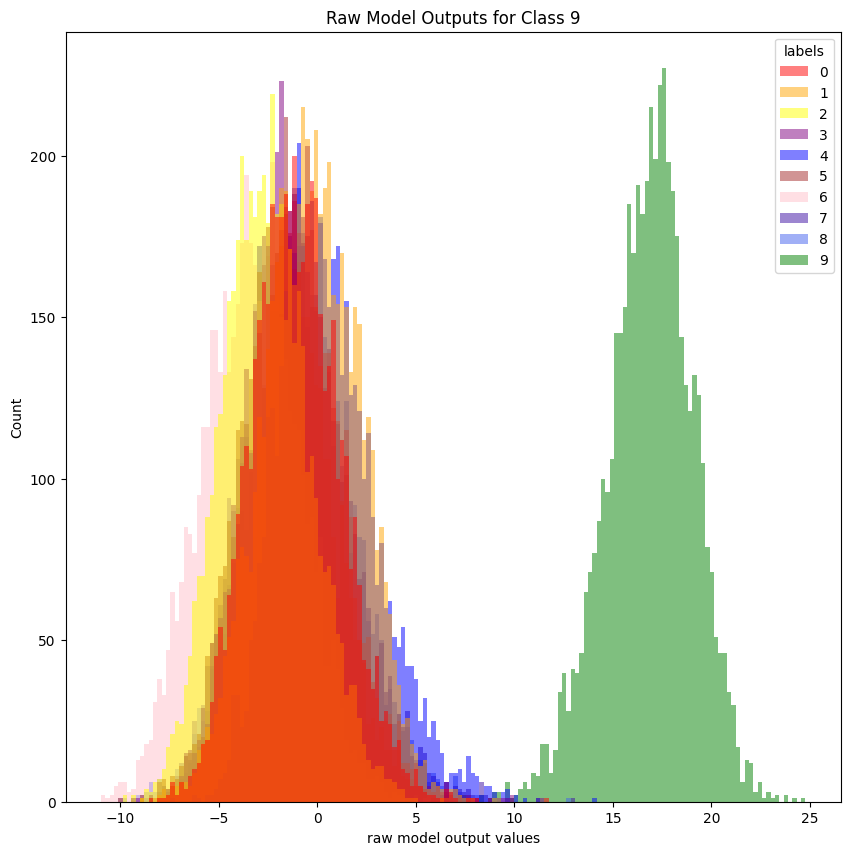

In [61]:
data_visualizer.plot_raw_histograms(resnet_hist_counts, data_path)

In [62]:
resnet_trainer = TrainerHelper(resnet_model, device, trainloader, valloader)

/content/drive/MyDrive/LinAlgProject/TrainerHelper.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = Variable(torch.tensor(target), requires_grad=False)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1, 10])) that is different to the input size (torch.Size([32, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCH 1:
Current loss: tensor(151.7507, grad_fn=<MseLossBackward0>)
EPOCH 2:
Current loss: tensor(157.6073, grad_fn=<MseLossBackward0>)
EPOCH 3:
Current loss: tensor(157.1529, grad_fn=<MseLossBackward0>)
EPOCH 4:
Current loss: tensor(155.3069, grad_fn=<MseLossBackward0>)
EPOCH 5:
Current loss: tensor(153.8032, grad_fn=<MseLossBackward0>)
EPOCH 6:
Current loss: tensor(155.4929, grad_fn=<MseLossBackward0>)
EPOCH 7:
Current loss: tensor(154.4066, grad_fn=<MseLossBackward0>)
EPOCH 8:
Current loss: tensor(155.7500, grad_fn=<MseLossBackward0>)
EPOCH 9:
Current loss: tensor(155.6711, grad_fn=<MseLossBackward0>)
EPOCH 10:
Current loss: tensor(155.8853, grad_fn=<MseLossBackward0>)
EPOCH 11:
Current loss: tensor(156.7448, grad_fn=<MseLossBackward0>)
EPOCH 12:
Current loss: tensor(156.0760, grad_fn=<MseLossBackward0>)
EPOCH 13:
Current loss: tensor(156.6474, grad_fn=<MseLossBackward0>)
EPOCH 14:
Current loss: tensor(156.6367, grad_fn=<MseLossBackward0>)
EPOCH 15:
Current loss: tensor(156.6298, gr

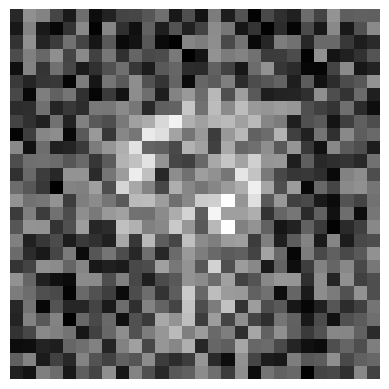

In [63]:
# NOTE: comment out which for the desired training
resnet_trainer.find_invertable_input(resnet_hist_counts, input_image, n_classes=10, model_type="resnet", save_path="drive/MyDrive/LinAlgProject/graphs/resnet/rand_invert_image_class", random=True)
#resnet_trainer.find_invertable_input(resnet_hist_counts, None, n_classes=10, img_class_dict=images_by_class, model_type="resnet", save_path="drive/MyDrive/LinAlgProject/graphs/resnet/closest_invert_image_class")
#resnet_trainer.find_invertable_input(resnet_hist_counts, None, n_classes=10, img_class_dict=images_by_class, model_type="resnet", save_path="drive/MyDrive/LinAlgProject/graphs/resnet/threshold_closest_invert_image_class", threshold=0.25)